# Data Preprocessing

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib as jb
from preprocessing import tweets_cleaning, process_tweet, model_fit
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [17]:
df = pd.read_csv("labeled_data.csv", index_col=0)

In [18]:
df.head() #returning the top 5 data just for info

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
df.info() # additional relevant informations

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [20]:
# seeing the random tweets in detail for further analysis
display(df[["tweet", "hate_speech"]].iloc[[0, 5, 17, 157, 512]])

,tweet,hate_speech
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1
17,""" bitch who do you love """,1
159,"""@KeyshawnSwag: Lmfao this cat started beating...",0
521,"""It's never too late to tag a bitch.""- @CyFyre",0


In [21]:
# identifying the classes in df
df["class"].unique()

array([2, 1, 0], dtype=int64)

In [ ]:
# checking class imbalance of original data labels
sns.countplot(x=df["class"], hue=df["class"], palette="Set3").set_title("Class Distribution.")
plt.savefig("./images/class_imbalance.png", bbox_inches = "tight", pad_inches=.5)

In [25]:
# - adding custom labels based on tweet class
# - 0 -> Hate Speech
# - 1 -> Offensive Language
# - 2 -> Neither
df["label"] = df["class"].map({0: "Hate Speech", 1: "Offensive Language", 2: "Neither"})

In [26]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [27]:
# cleaning tweets
df["tweet"] = df["tweet"].apply(tweets_cleaning)

In [28]:
# re-assigning the dataframe with just tweet and label, which we created based on class
df=df[["tweet","label"]]
df.head()

,tweet,label
0,as a woman you shouldnt complain about clea...,Neither
1,boy dats coldtyga dwn bad for cuffin dat ho...,Offensive Language
2,dawg you ever fuck a bitch and she sta to...,Offensive Language
3,she look like a tranny,Offensive Language
4,the shit you hear about me might be true or...,Offensive Language


In [29]:
# as we saw till now there are many unwanted informations and characters in tweet.
# we need to refine / process the tweets such that the tweet just contains a plain english sentence.
df["tweet"]=df["tweet"].apply(tweets_cleaning)
df.head()

,tweet,label
0,as a woman you shouldnt complain about cleani...,Neither
1,boy dats coldtyga dwn bad for cuffin dat hoe ...,Offensive Language
2,dawg you ever fuck a bitch and she sta to cry...,Offensive Language
3,she look like a tranny,Offensive Language
4,the shit you hear about me might be true or i...,Offensive Language


In [30]:
# assigning variables to essential columns
data = df["tweet"]
label = df["label"]

stop_words = set(stopwords.words("english"))

# applying the above function to our `clean_tweets`
processed_data = list(map(process_tweet, data))

# getting count of all unique words in the corpus
total_count = set()
for data in processed_data:
    total_count.update(data)
len(total_count)

20274

In [31]:
# transforming `processed_data` into a readable list
processed_data_flat_list = [item for sublist in processed_data for item in sublist]

# getting frequency distribution
clean_corpus_freq_dist = FreqDist(processed_data_flat_list)

# top 10 words in cleaned corpus
clean_corpus_freq_dist.most_common(10)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570)]

In [32]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for data in processed_data:
    lemmed = " ".join([lemmatizer.lemmatize(w) for w in data])
    lemmatized_output.append(lemmed)

X_lem = lemmatized_output
y_lem = label

# Feature Engineering

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

In [34]:
# instantiating tf_idf vectorizer
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2))

# transforming tokenized data into sparse matrix format
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

non_zero_cols = X_train_tfidf.nnz / float(X_train_tfidf.shape[0])
print("Average Number of Non-Zero Elements: {}".format(non_zero_cols))
sparse_percent = 1 - (non_zero_cols / float(X_train_tfidf.shape[1]))
print("Percentage of columns containing ZERO: {}".format(sparse_percent))

Average Number of Non-Zero Elements: 13.364319580349036
Percentage of columns containing ZERO: 0.9998720456544018


# Model Selection & Training

## Baseline Random Forest

In [35]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=0)

In [36]:
%%time
rf_baseline.fit(X_train_tfidf, y_train)
rf_test_preds = rf_baseline.predict(X_test_tfidf)

CPU times: total: 8min 4s
Wall time: 9min 43s


In [37]:
rf_precision = precision_score(y_test, rf_test_preds, average="weighted")
rf_recall = recall_score(y_test, rf_test_preds, average="weighted")
rf_f1_weighted = f1_score(y_test, rf_test_preds, average="weighted")

# printing scores
print("Precision: {:.4}".format(rf_precision))
print("Recall: {:.4}".format(rf_recall))
print("Weighted F1 Score: {:.4}".format(rf_f1_weighted))

Precision: 0.8691
Recall: 0.884
Weighted F1 Score: 0.8727


In [38]:
%%time

# we can take the cross validated F1 for the training set to determine whether each model is overfit or underfit.
rf_f1_cv = cross_val_score(rf_baseline, X_train_tfidf, y_train, scoring='f1_weighted', cv=5)
rf_mean_cv = round(rf_f1_cv.mean(), 6)

CPU times: total: 44min 42s
Wall time: 54min 35s


In [39]:
# is this model overfit or underfit?
rf_fit = model_fit(rf_mean_cv, rf_f1_weighted)
rf_fit

'underfit'

In [40]:
metric_dict = {}
metric_dict['Baseline Random Forest - TFIDF'] = {
    'precision': rf_precision,
    'recall': rf_recall,
    'weighted_f1': rf_f1_weighted,
    'fit': rf_fit
}

## Baseline Logistic Regression

In [41]:
log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [42]:
%%time
log_reg_baseline.fit(X_train_tfidf, y_train)
log_reg_test_preds = log_reg_baseline.predict(X_test_tfidf)

CPU times: total: 10.7 s
Wall time: 8.66 s


c:\Users\satya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
log_reg_precision = precision_score(y_test, log_reg_test_preds, average='weighted')
log_reg_recall = recall_score(y_test, log_reg_test_preds, average='weighted')
log_reg_f1 = f1_score(y_test, log_reg_test_preds, average='weighted')

# printing scores
print("Precision: {:.4}".format(log_reg_precision))
print("Recall: {:.4}".format(log_reg_recall))
print("Weighted F1 Score: {:.4}".format(log_reg_f1))

Precision: 0.8944
Recall: 0.864
Weighted F1 Score: 0.8746


In [45]:
%%time
log_reg_f1_cv = cross_val_score(log_reg_baseline, X_train_tfidf, y_train, scoring='f1_weighted', cv=5)
log_reg_mean_cv = round(log_reg_f1_cv.mean(), 6)

c:\Users\satya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

CPU times: total: 1min 43s
Wall time: 57.6 s


c:\Users\satya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
# is this model overfit or underfit?
log_reg_fit = model_fit(log_reg_mean_cv, log_reg_f1)
log_reg_fit

'overfit'

In [47]:
# adding scores to metric_dict
metric_dict['Baseline Log Reg - TFIDF'] = {
    'precision': log_reg_precision,
    'recall': log_reg_recall,
    'weighted_f1': log_reg_f1,
    'fit': log_reg_fit
}

## Baseline Support Vector Machine

In [48]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

In [49]:
%%time 
# fit the training dataset on the classifier
SVM_baseline.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(X_test_tfidf)

CPU times: total: 1min 56s
Wall time: 2min 14s


In [50]:
SVM_precision = precision_score(y_test, SVM_test_preds, average='weighted')
SVM_recall = recall_score(y_test, SVM_test_preds, average='weighted')
SVM_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
print("Precision: {:.4}".format(SVM_precision))
print("Recall: {:.4}".format(SVM_recall))
print("Weighted F1 Score: {:.4}".format(SVM_f1_score))

Precision: 0.8948
Recall: 0.8804
Weighted F1 Score: 0.8858


In [51]:
%%time
base_SVM_f1_cv = cross_val_score(SVM_baseline, X_train_tfidf, y_train, scoring='f1_weighted', cv=5)
base_SVM_mean_cv = round(base_SVM_f1_cv.mean(), 6)

CPU times: total: 4min 56s
Wall time: 5min 51s


In [52]:
# is this model overfit or underfit?
base_SVM_fit = model_fit(base_SVM_mean_cv, SVM_f1_score)
base_SVM_fit

'overfit'

In [53]:
# adding scores to metric_dict
metric_dict['Baseline SVM - TFIDF'] = {
    'precision': SVM_precision,
    'recall': SVM_recall,
    'weighted_f1': SVM_f1_score,
    'fit': base_SVM_fit
}

In [54]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,weighted_f1,fit
Baseline Random Forest - TFIDF,0.869110,0.884002,0.872730,underfit
Baseline Log Reg - TFIDF,0.894377,0.864031,0.874598,overfit
Baseline SVM - TFIDF,0.894768,0.880371,0.885761,overfit


## Conclusion

# Hyperparameter Tuning

In [55]:
baseline_log_reg = LogisticRegression(class_weight='balanced', random_state=50)

In [56]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [57]:
# instantiate Grid Search CV with F1 Weighted metric
grid_log_reg = GridSearchCV(baseline_log_reg, param_dict, cv=5, scoring='f1_weighted', verbose=1)

In [58]:
%%time
# fit the grid search to our data
grid_log_reg.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\satya\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

CPU times: total: 29min 40s
Wall time: 32min 19s


c:\Users\satya\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=50),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'sag']},
             scoring='f1_weighted', verbose=1)

In [59]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_log_reg.best_score_)
print('Best Hyperparameters:', grid_log_reg.best_params_)
print('Model object with best parameters: ')
print(grid_log_reg.best_estimator_)

F1 Score: 0.8891487235199419
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Model object with best parameters: 
LogisticRegression(C=10, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')


In [60]:
# Predict the response for trainingg dataset
grid_base_y_pred_train = grid_log_reg.best_estimator_.predict(X_train_tfidf)

# predict the test set
grid_base_y_pred_test = grid_log_reg.best_estimator_.predict(X_test_tfidf)

In [61]:
tuned_base_precision = precision_score(y_test, grid_base_y_pred_test, average='weighted')
tuned_base_recall = recall_score(y_test, grid_base_y_pred_test, average='weighted')
tuned_base_f1_score = f1_score(y_test, grid_base_y_pred_test, average='weighted')

# printing scores
print("Precision: {:.4}".format(tuned_base_precision))
print("Recall: {:.4}".format(tuned_base_recall))
print("Weighted F1 Score: {:.4}".format(tuned_base_f1_score))

Precision: 0.8871
Recall: 0.8897
Weighted F1 Score: 0.8881


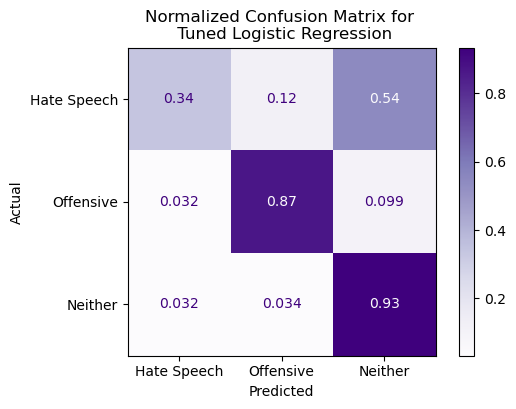

In [62]:
# Compute the normalized confusion matrix
cm = confusion_matrix(y_test, grid_log_reg.predict(X_test_tfidf), normalize='true')

# Create ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hate Speech", "Offensive", "Neither"])

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap=plt.cm.Purples, ax=ax)
plt.title('Normalized Confusion Matrix for \n Tuned Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./images/normalized_log_reg_matrix.png', bbox_inches="tight", pad_inches=0.5)
plt.show()


In [63]:
jb.dump(log_reg_baseline, "hate_speech_model.pkl")
jb.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [ ]:
complete github project link is mentioned below:
                                            https://github.com/SatyamDhungana01/ML_CW